# Breakthrough model 1


author: bebu

date: 18.09.2025

description: Simple model to calculate the spacial (1D) co2 concentration in a breakthrough column (in air flow direction) and over time. All values are calculated per squaremeter of inlet area. Assumptions this model relies on:
- air flow in equals air flow out (i.e. the amound of co2 molecules being taken up in the column is neglegitable compared to the total amount of air molecules)
- the mass transfer coefficient (MTC) K_initial [mmol/(m^2 s kPa)] stays constant throughout time (i.e. it does not change with loading OR loading is constant throughout time as it would be in continuous operation.)

## Imports & Functions

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

def K_eff(uptake, K_initial, cap, V_liq):
    """Calculate effective mass transfer coefficient based on current uptake.
    
    Args:
        uptake (float): Current uptake in mol.
        K_initial (float): Initial mass transfer coefficient in mmol/(m^2 s kPa).
        cap (float): Cyclic uptake capacity in mol/L.
        V_liq (float): Liquid sorbent volume in L.
        N (int): Number of sections in the column.
        
    Returns:
        float: Effective mass transfer coefficient in mmol/(m^2 s kPa).
    """
    if uptake >= cap * V_liq:
        return 0.0
    else:
        return K_initial * (1 - uptake / (cap * V_liq))
    

def plot_model_results(x, n2l, l, v, SSA):
    # Custom colormap
    cmap = LinearSegmentedColormap.from_list("blue_yellow", ["blue", "yellow"])
    l_N = l / n2l.shape[1] # l/ N
    
    # --- Figure with GridSpec: 3 rows, 2 cols ---
    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(4, 3, width_ratios=[20, 1, 1], height_ratios=[2, 1, 2, 1])
    
    ax1 = fig.add_subplot(gs[0, 0])          # full heatmap
    ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)  # outlet profile
    ax3 = fig.add_subplot(gs[2, 0], sharex=ax1)  # tail heatmap
    ax4 = fig.add_subplot(gs[3, 0], sharex=ax1)  # tail heatmap
    cax = fig.add_subplot(gs[:, 1])          # colorbar (shared)
    cax2 = fig.add_subplot(gs[:, 2])          # colorbar uptake (shared)
    
    # --- Top: full heatmap ---
    im = ax1.imshow(
        x[:,:].T * 10, 
        cmap="Reds", vmin=0, vmax=400,
        interpolation="nearest", origin="lower", aspect="auto",
    
    )
    ax1.set_title(f"Breakthrough column\nl: {l} m, v: {v} m/s, SSA: {SSA} m$^2$/m$^3$")
    ax1.set_ylabel(f"segment # (bottom: air in, top: air out)\n"
                   f"each segment corresponds to {l_N} m")
    ax1.set_xticks(np.arange(x.shape[0]))                       # ticks at 0..N-1
    ax1.set_xticklabels(np.arange(1, x.shape[0] + 1))           # labels 1..N
    
    # --- Middle: outlet + CF ---
    line1, = ax2.plot(x[:, -1]*10, color="black", label="outlet CO$_2$")
    ax2.set_ylabel("outlet CO$_2$\n[ppm]", color="black")
    
    ax2b = ax2.twinx()
    cf = (400 - x[:, -1]*10) / 4
    line2, = ax2b.plot(cf, color="red", label="CF")
    ax2b.set_ylabel("CF [%]", color="red")
    
    ax2.tick_params(axis='y', colors=line1.get_color())
    ax2b.tick_params(axis='y', colors=line2.get_color())
    
    # --- Bottom middle: tail heatmap ---
    im2 = ax3.imshow(
        n2l[:, :].T * 10,
        cmap="Greens", vmin=0, vmax=n2l.max(),
        interpolation="nearest", origin="lower", aspect="auto"
    )
    ax3.set_title(f"uptake")
    ax3.set_xlabel(f"time (x {dt} s)")
    ax3.set_ylabel(f"tail section (segment {p} onward)\n{l_N} m each")
    ax3.set_ylabel(f"segment # (bottom: air in, top: air out)\n"
                   f"each segment corresponds to {l_N} m")
    ax3.set_yticks(np.arange(n2l.shape[1]))                       # ticks at 0..N-1
    ax3.set_yticklabels(np.arange(1, n2l.shape[1] + 1))           # labels 1..N
    
    line3, = ax4.plot(np.sum(n2l, axis=1), color="green", label="outlet CO$_2$")
    ax4.set_ylabel(f"instant. uptake\n[mol/{dt}s]", color="green")
    
    ax4b = ax4.twinx()
    n_total = integrated = np.cumsum(np.sum(n2l, axis=1))
    line4, = ax4b.plot(n_total, color="black", label="cum. uptake")
    ax4b.set_ylabel("cum. uptake\n[mol]", color="black")
    #
    ax4.tick_params(axis='y', colors=line3.get_color())
    ax4b.tick_params(axis='y', colors=line4.get_color())
    
    # --- Shared colorbar ---
    fig.colorbar(im, cax=cax, label=f"gas phase CO$_2$ concentration [ppm]")
    fig.colorbar(im2, cax=cax2, label=f"uptake of co2 [mol] (per {dt} s and $m^2$ inlet area)")
    
    plt.tight_layout()
    plt.show()

def run_model(K_initial, l, SSA, v, dt, N, T):
    # derived parameters
    l_N = l/N # length of one section [m]
    V_N = l_N # volume of one section [m^3]
    ds = v * dt / l_N # number of sections (that air travels in one time step)
    ds_int_flag = ds.is_integer() # flag if ds is integer
    #p = 2 # number of sections before inlet (for airspeeds larger than l_N/dt) -> could be set to np.ceil(ds)
    p = int(np.ceil(ds)) # number of sections before inlet (for airspeeds larger than l_N/dt)
    if ds_int_flag:
        print(f"ds = {ds} is integer.")
    print(f"ds: {ds} [segments per timesteps], -> p: {p} [segments before inlet]")

    # concentration matrix
    x = np.ones((T, N+p)) * np.nan # [Pa]. rows: time steps; collumns: sections

    # set initial and boundary conditions: 
    # 1) x = 40 Pa for all time steps(=rows) at inlet (p initial sections=columns);
    x[:, 0:p] = 40 # initial concentration in inlet [Pa]
    # 2) x = 40 Pa at t=0 for all sections:columns
    x[0, :] = 40 # initial concentration in collumn [Pa]
    x

    # mol in gase phase matrix (mol per time step and section)
    n = np.ones((T, N)) * np.nan # rows: time steps; collumns: sections
    # uptake matrix (mol per time step and section)
    n2l = np.ones((T, N)) * np.nan # rows: time steps; collumns: sections

    # total uptake (over time)
    n_total_t = np.zeros(T) # total uptake per time step [mol]
    for t in range(0, T):
        #print(f"t = {t}")
        # 1) calculate uptake n for section i at time step t
        n2l[t, :] = x[t,p:N+p] * K_initial * 1e-6 * SSA * l_N * dt # uptake gas molecules to liquid [mol]
        #print(f"n2l = {n2l}")
        n[t, :] = x[t,p:N+p] * V_N / (8.314 * 298) - n2l[t, :]# remaining in gas phase [mol]
        if (n[t, :] < 0.0).any(): # check if remaining in gas phase is negative
            print(f"Warning: negative remaining in gas phase! setting to zero. time step: {t}, index: {np.where(n[t, :] < 0.0)}")
            n2l[t, n[t, :] < 0.0] = x[t,p:N+p][n[t, :] < 0.0] * V_N / (8.314 * 298) # limit uptake to remaining in gas phase
            n[t, n[t, :] < 0.0] = 0.0
        #n2l[t, :] = x[t,p:N+p] * K_initial * 1e-6 * SSA * l_N * dt * 44 # uptake [g_co2]

        # 2) calc remaining concentration after uptake:
        x[t, p:N+p] = n[t, :] * 8.314 * 298 / (V_N) # new concentration [Pa]
        #print(f"calculated remaind partial pressure in gasphase (at end of timestep {t}): {x[t, p:N+p]}")

        if t < T - 1:
            # 3) calc next concentration x for all sections (p:N+p) at time step t+1
            if ds_int_flag:# if ds is int(ds)
                x[t+1, p:N+p] = x[t, (p-int(ds)):(N+p-int(ds))] # new concentration (in next time step) equals the one 
    
    return x, n2l, n

## Set parameter

In [79]:
# model parameters
dt = 1 # time step [s]
N = 4 # number of sections in the collumn
T = 5 # total simulation time steps

# sorbent parameters
K_initial = 1.5 # initial mass transfer coefficient [mmol/(m^2 s kPa)]
cap = 2.0 # cyclic uptake capacity [mol/L]

# process design parameters
l = 4 # collumn depth [m]
SSA = 210 # sorbent specific surface area [m^2/m^3]
# process operation parameters
v = 1.0 # air speed [m/s]
V_liq = 0.5 # liquid sorbent volume [L]

ds = 1.0 is integer.
ds: 1.0 [segments per timesteps], -> p: 1 [segments before inlet]


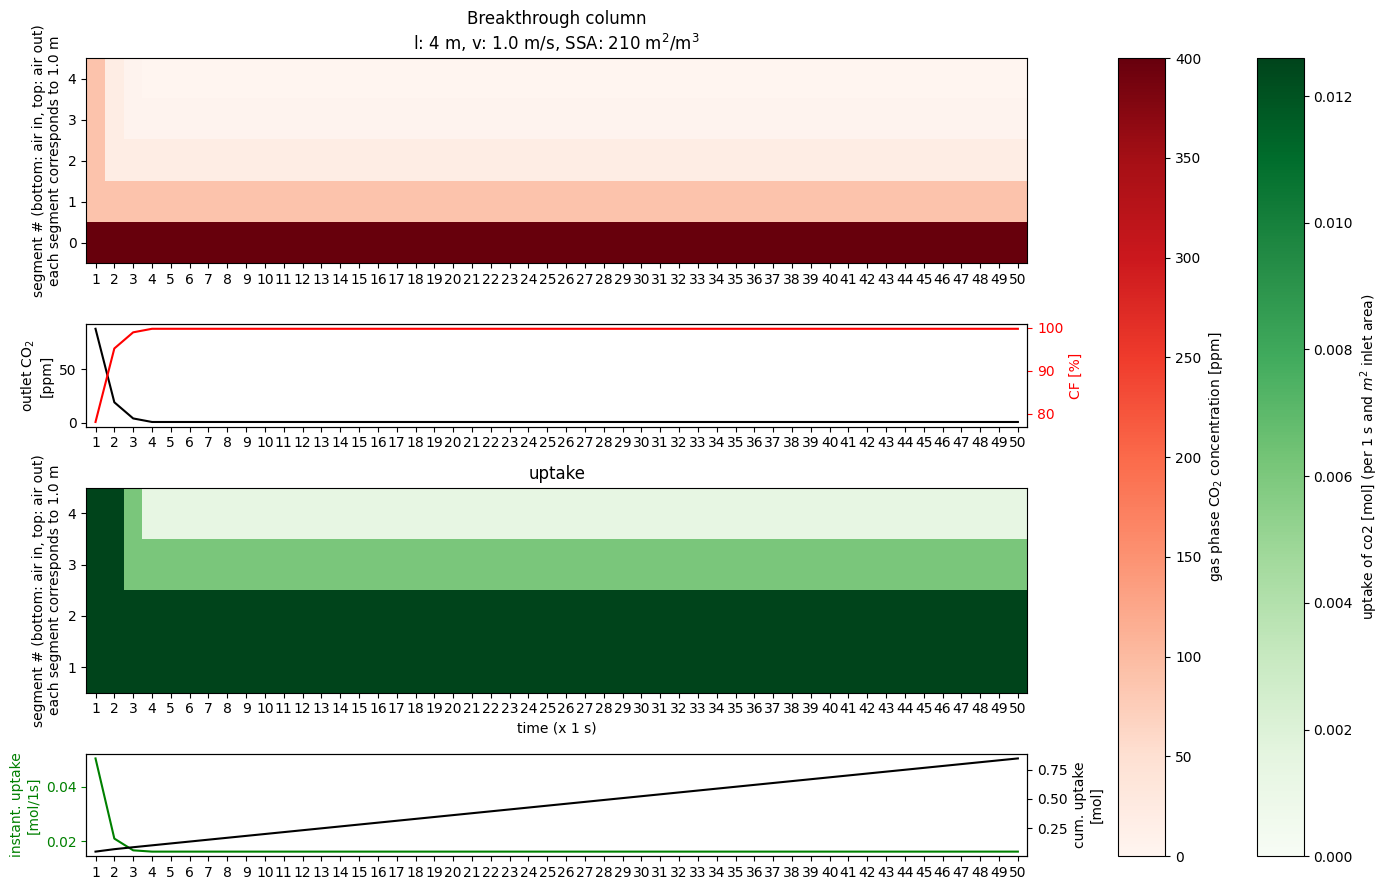

In [83]:
x, n2l, n = run_model(
    # sorbent parameters
    K_initial=1.5,    # initial mass transfer coefficient [mmol/(m^2 s kPa)]

    # process design parameters
    l = 4, # collumn depth [m]
    SSA = 210, # sorbent specific surface area [m^2/m^3]
    # process operation parameters
    v = 1.0, # air speed [m/s]

    # model parameters
    N = 4, # number of sections in the collumn
    T = 50, # total simulation time steps
    dt = 1, # time step [s]
    )

plot_model_results(x, n2l, l, v, SSA)

## assessment 1: do model parameter converge to some CF and instantaneous uptake for different 